Purpose of this notebook: Translate temperature data to degree days and calculate climatologies.

In [ ]:
from pathlib import Path
import json
import pandas as pd 
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt

In [ ]:
prefix = "DD25"       # set to TDD for Thawing Degree Days
lastyear = 2024

config = {
    "TDD": {
        "deltaT": 32
    },
    "DD20": {
        "deltaT": 20
    },
    "DD25": {
        "deltaT": 25
    },
}

PROJPATH = Path().resolve().parent
datapath = PROJPATH / "data/weatherstations/ACIS/stationdata/RFC_new_model"
outpath = PROJPATH / f"data/weatherstations/ACIS/{prefix}"
stations = sorted(list(datapath.glob("*.csv")))

finalstations = PROJPATH / "data/stationdata_for_breakup/selectedstations.json"
with open(finalstations) as src:
    st = json.load(src)

finalset = sorted(list(set(sum(st.values(), []))))
finalset

['ANCHORAGE_MERRILL_FIELD',
 'BETHEL_AP',
 'BETTLES_AP',
 'BIG_DELTA_AP',
 'CHICKEN',
 'EAGLE',
 'FAIRBANKS_INTL_AP',
 'GULKANA_AP',
 'KENAI_AP',
 'KOTZEBUE_AP',
 'MCGRATH_AP',
 'MCKINLEY_PARK',
 'NENANA_MUN_AP',
 'NOME_AP',
 'NORTHWAY_AP',
 'NORTH_POLE',
 'SITKA_AP',
 'TALKEETNA_AP',
 'TANANA_AP']

In [ ]:
colnames = ["Tmax_f", "Tmin_F", "Tavg_F", "sd_m", "swe"]

def station2df(stationpth):
    df = pd.read_csv(stationpth, header=1, 
        names=colnames, parse_dates=True)
    df = df.replace("M", "-9999",)
    df['Tavg_F'] = df['Tavg_F'].astype(float)
    df['year'] = df.index.year
    return df 

def get_MAMJ_dd(stationdf):
    stationdf.drop(columns=["Tmax_f", "Tmin_F", "sd_m", "swe"], inplace=True)
    tempdf = stationdf[stationdf.index.month.isin([3, 4, 5, 6])]
    tempdf = tempdf[tempdf.index.year < lastyear+1]
    return tempdf

def julian_day(rowind):
    timed = dt.datetime.strftime(rowind, '%j')
    return int(timed)

def days_past_march1(rowind):
    march1 = dt.date(rowind.year, 3, 1)
    timed = rowind.date() - march1
    return timed.days

def get_dddf(tempdf):
    tempdf['julian_day'] = list(tempdf.index.to_series().apply(julian_day))
    tempdf['dd'] = tempdf['Tavg_F'].astype('float') - config[prefix]['deltaT']
    tempdf.loc[tempdf['dd'] < 0, 'dd'] = 0
    tdddf = tempdf.groupby(['year', "julian_day", 'Tavg_F'], as_index=False)['dd'].sum().assign(
        dd_cumul=lambda x: x.groupby('year')['dd'].cumsum()
    ) 
    return tdddf

def get_pivotdf(tdddf, index="julian_day", column='year', value='dd_cumul'):
    pivotdf = tdddf.pivot(index=[index], columns=[column], values=[value] )
    pivotdf.columns = pivotdf.columns.get_level_values(1)
    return pivotdf

def station2pivot(stationdf, index="julian_day", column='year', value='dd_cumul'):
    return get_pivotdf(get_dddf(get_MAMJ_dd(stationdf)), index=index, column=column, value=value)


In [ ]:
for stationpth in stations:
    name = stationpth.stem[:-21]
    testdf = get_MAMJ_dd(station2df(stationpth))
    missing = pd.DataFrame(testdf[testdf.Tavg_F==-9999].groupby('year').size().rename('count_missing'))
    significant_missing = missing[missing.count_missing > 5]
    missing_climatology_years = set(missing.index).intersection(set(range(1991, 2021)))
    mising_sig_climatology_years = set(significant_missing.index).intersection(set(range(1991, 2021)))
    print(f"{name},{len(missing)},{len(significant_missing)},{len(missing_climatology_years)},{len(mising_sig_climatology_years)}")
    

ANCHORAGE_MERRILL_FIELD,28,18,15,7
BETHEL_AIRPORT,4,0,3,0
BETTLES_AIRPORT,3,1,2,0
BIG_DELTA_AIRPORT,8,5,5,4
CHICKEN,28,20,17,9
EAGLE,29,5,19,2
FAIRBANKS_INTL_AP,0,0,0,0
GULKANA_AIRPORT,7,1,3,1
KENAI_AIRPORT,9,1,4,0
KOTZEBUE_AIRPORT,1,1,1,1
MCGRATH_AP,4,2,0,0
MCKINLEY_PARK,23,2,14,1
NENANA_MUNICIPAL_AIRPORT,35,25,21,13
NENANA_MUN_AP,32,20,19,9
NOME_AIRPORT,0,0,0,0
NORTHWAY_AIRPORT,2,1,0,0
NORTH_POLE,29,4,17,2
SITKA_AIRPORT,4,0,2,0
TALKEETNA_AIRPORT,0,0,0,0
TANANA_AIRPORT,6,2,2,1


### make climatologies

In [ ]:
outfile_rejected = outpath / "DD_climatology_rejectedstations.txt"
outdir_clim = outpath / "dd_climatologies"

In [ ]:
for stationpth in stations:
    name = stationpth.stem[:-21]
    testdf = get_MAMJ_dd(station2df(stationpth))
    missing = pd.DataFrame(testdf[testdf.Tavg_F==-9999].groupby('year').size().rename('count_missing'))
    significant_missing = missing[missing.count_missing > 5]
    mising_sig_climatology_years = set(significant_missing.index).intersection(set(range(1991, 2021)))
    if len(mising_sig_climatology_years) > 10:
        with open(outfile_rejected, 'a') as dst:
            outtxt = f"{name} excluded: {len(mising_sig_climatology_years)} years 1991-2020 with more than 5 March-June days missing\n"
            dst.write(outtxt)
            print(outtxt)
    else:
        testdf = testdf[(testdf.year > 1990) & (testdf.year < 2021) & (~testdf.year.isin(mising_sig_climatology_years))].replace(-9999, np.nan)
        testdf['Tavg_F'] = testdf.Tavg_F.astype(float)
        testdf = testdf.interpolate(method='linear', axis=0)
        climatology = pd.DataFrame(get_pivotdf(get_dddf(testdf), value='Tavg_F').mean(axis=1), columns=['Tavg_F'])
        climatology['dd'] = climatology['Tavg_F'] - config[prefix]["deltaT"]
        climatology.loc[climatology['dd'] < 0, 'dd'] = 0
        outfn = f"{name}_clim1991_2020.csv"
        with open(outdir_clim / outfn, 'w') as dst:
            dst.write(f"# {name}\n")
            dst.write(f"# 1991-2020 climatology of T_avg and {prefix} for ACIS station\n")
            if mising_sig_climatology_years:
                dst.write(f"# Excluded years (more than 5 days of missing data): {', '.join(map(str, mising_sig_climatology_years))}\n")
            else:
                dst.write("# No years excluded (all years had 5 or fewer days of missing data)\n")
            dst.write("#\n")
            
            climatology.to_csv(dst, float_format='%.2f')
        
    

NENANA_MUNICIPAL_AIRPORT excluded: 13 years 1991-2020 with more than 5 March-June days missing



Plot climatologies

In [ ]:
clims = sorted(list(outdir_clim.glob("*.csv")))

Text(0, 0.5, 'Degree days > 25 (F)')

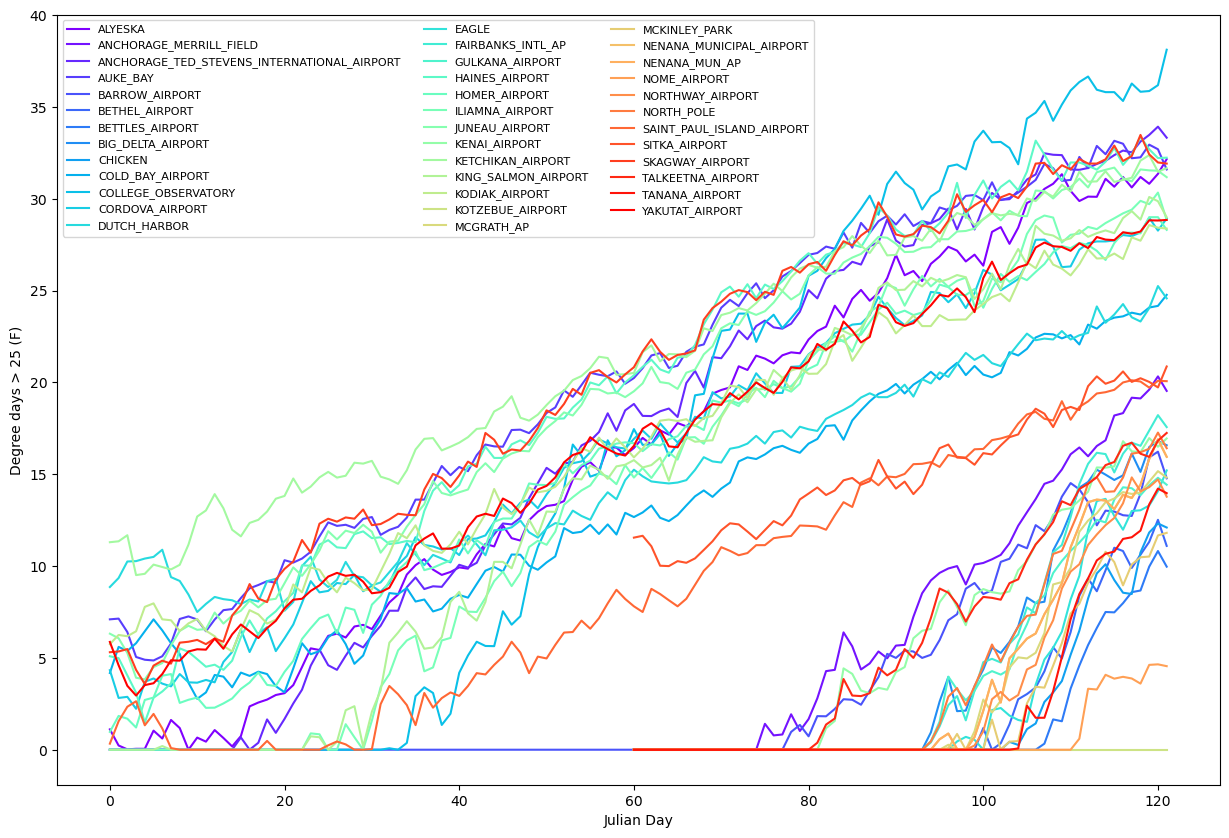

In [ ]:
for fp in clims:
    name = fp.stem[:-14]
    testdf = pd.read_csv(fp, header=4, index_col=0)
    try:
        aggdf[name] = testdf['dd']
    except (NameError, TypeError):
        aggdf = pd.DataFrame(testdf['dd'])
        aggdf.columns = [name]

colors = plt.cm.rainbow(np.linspace(0, 1, len(aggdf.columns)))

fig, ax = plt.subplots(figsize=(15, 10))
aggdf.plot(ax=ax, legend=False, color=colors)
ax.legend(fontsize=8, ncol=3, loc='upper left')
ax.set_xlabel('Julian Day')
ax.set_ylabel(f'Degree days > {config[prefix]["deltaT"]} (F)')

### Make tdd and cumul tdd datasets

In [ ]:
outpath, datapath

(PosixPath('/Users/chris/Projects/2023_Riverice/data/weatherstations/ACIS/DD25'),
 PosixPath('/Users/chris/Projects/2023_Riverice/data/weatherstations/ACIS/stationdata/RFC_new_model'))

In [ ]:
finalset

['ANCHORAGE_MERRILL_FIELD',
 'BETHEL_AP',
 'BETTLES_AP',
 'BIG_DELTA_AP',
 'CHICKEN',
 'EAGLE',
 'FAIRBANKS_INTL_AP',
 'GULKANA_AP',
 'KENAI_AP',
 'KOTZEBUE_AP',
 'MCGRATH_AP',
 'MCKINLEY_PARK',
 'NENANA_MUN_AP',
 'NOME_AP',
 'NORTHWAY_AP',
 'NORTH_POLE',
 'SITKA_AP',
 'TALKEETNA_AP',
 'TANANA_AP']

In [ ]:
datasuffix = "_T_max_min_avg_sd_swe.csv"
climdir = outpath / "dd_climatologies"
clims = sorted(list(climdir.glob("*.csv")))

nmissing = 10

for fp in clims:
    name = fp.stem[:-14]
    if not name.replace('AIRPORT', 'AP').replace('MUNICIPAL', 'MUN') in finalset: 
        print(f"Excluding {name} - not in forecast")
        continue
    else: 
        print(f"Working on {name}")
    stationpth = datapath / f"{name}{datasuffix}"
    climdf = pd.read_csv(fp, header=4, index_col=0)
    testdf = get_MAMJ_dd(station2df(stationpth))
    missing = pd.DataFrame(testdf[testdf.Tavg_F==-9999].groupby('year').size().rename('count_missing'))
    significant_missing = missing[missing.count_missing > nmissing]
    missing_years = sorted(list(significant_missing.index))
    if 2024 in missing_years: missing_years.remove(2024)
    print(missing_years)
    print(name, missing_years)
    testdf = testdf[~testdf.year.isin(missing_years)]
    testdf['julian_day'] = list(testdf.index.to_series().apply(julian_day))
    testdf['Tavg_clim'] = testdf.julian_day.apply(lambda x: climdf.iloc[x-60]['Tavg_F'])
    testdf = testdf.replace(-9999, np.nan)
    testdf['Tavg_F'] = testdf.Tavg_F.astype(float)
    testdf['Tavg_F'].fillna(testdf.Tavg_clim, inplace=True)
    testdf = testdf[['Tavg_F', 'year']]
    # make string for metadata for missing years
    if missing_years:
        missingstr = f"# Excluded years (more than {str(nmissing)} days of missing data): {', '.join(map(str, missing_years))}\n"
    else:
        missingstr = f"# No years excluded (all years had {str(nmissing)} or fewer days of missing data)\n"
    # write TDD files
    outdf = get_pivotdf(get_dddf(testdf), value='dd')
    with open(outpath / f"dd_bystation/{name}_yearly_DD.csv", 'w') as dst:
        dst.write(f"# {name}\n")
        dst.write(f"# Degree days degree days > {config[prefix]['deltaT']} starting March 1 from ACIS, gaps filled from climatology\n")
        dst.write(missingstr)
        dst.write("#\n")
        outdf.to_csv(dst, float_format='%.2f')
    # write cumul tdd files
    outdf = get_pivotdf(get_dddf(testdf))
    with open(outpath / f"dd_cumul_bystation/{name}_yearly_{prefix}_cumul.csv", 'w') as dst:
        dst.write(f"# {name}\n")
        dst.write(f"# Cumulative degree days > {config[prefix]['deltaT']} starting March 1 from ACIS, gaps filled from climatology\n")
        dst.write(missingstr)
        dst.write("#\n")
        outdf.to_csv(dst, float_format='%.2f')

    

Working on ANCHORAGE_MERRILL_FIELD
[1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997]
ANCHORAGE_MERRILL_FIELD [1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997]
Working on BETHEL_AIRPORT


/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_33196/2282478684.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  testdf['Tavg_F'].fillna(testdf.Tavg_clim, inplace=True)


[]
BETHEL_AIRPORT []


/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_33196/2282478684.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  testdf['Tavg_F'].fillna(testdf.Tavg_clim, inplace=True)


Working on BETTLES_AIRPORT
[]
BETTLES_AIRPORT []


/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_33196/2282478684.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  testdf['Tavg_F'].fillna(testdf.Tavg_clim, inplace=True)


Working on BIG_DELTA_AIRPORT
[1990, 1991, 1992, 1993]
BIG_DELTA_AIRPORT [1990, 1991, 1992, 1993]


/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_33196/2282478684.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  testdf['Tavg_F'].fillna(testdf.Tavg_clim, inplace=True)


Working on CHICKEN
[1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997]
CHICKEN [1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997]
Working on EAGLE


/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_33196/2282478684.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  testdf['Tavg_F'].fillna(testdf.Tavg_clim, inplace=True)


[1982, 2009, 2022]
EAGLE [1982, 2009, 2022]


/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_33196/2282478684.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  testdf['Tavg_F'].fillna(testdf.Tavg_clim, inplace=True)


Working on FAIRBANKS_INTL_AP
[]
FAIRBANKS_INTL_AP []


/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_33196/2282478684.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  testdf['Tavg_F'].fillna(testdf.Tavg_clim, inplace=True)


Working on GULKANA_AIRPORT
[1995]
GULKANA_AIRPORT [1995]


/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_33196/2282478684.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  testdf['Tavg_F'].fillna(testdf.Tavg_clim, inplace=True)


Working on KENAI_AIRPORT
[]
KENAI_AIRPORT []


/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_33196/2282478684.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  testdf['Tavg_F'].fillna(testdf.Tavg_clim, inplace=True)


Working on KOTZEBUE_AIRPORT
[2019]
KOTZEBUE_AIRPORT [2019]


/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_33196/2282478684.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  testdf['Tavg_F'].fillna(testdf.Tavg_clim, inplace=True)


Working on MCGRATH_AP
[]
MCGRATH_AP []


/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_33196/2282478684.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  testdf['Tavg_F'].fillna(testdf.Tavg_clim, inplace=True)


Working on MCKINLEY_PARK
[]
MCKINLEY_PARK []


/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_33196/2282478684.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  testdf['Tavg_F'].fillna(testdf.Tavg_clim, inplace=True)
/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_33196/2282478684.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting va

Working on NENANA_MUNICIPAL_AIRPORT
[1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2002, 2003, 2017, 2023]
NENANA_MUNICIPAL_AIRPORT [1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2002, 2003, 2017, 2023]
Working on NOME_AIRPORT
[]
NOME_AIRPORT []


/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_33196/2282478684.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  testdf['Tavg_F'].fillna(testdf.Tavg_clim, inplace=True)


Working on NORTHWAY_AIRPORT
[1985]
NORTHWAY_AIRPORT [1985]


/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_33196/2282478684.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  testdf['Tavg_F'].fillna(testdf.Tavg_clim, inplace=True)


Working on NORTH_POLE
[2007, 2008]
NORTH_POLE [2007, 2008]


/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_33196/2282478684.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  testdf['Tavg_F'].fillna(testdf.Tavg_clim, inplace=True)


Working on SITKA_AIRPORT
[]
SITKA_AIRPORT []


/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_33196/2282478684.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  testdf['Tavg_F'].fillna(testdf.Tavg_clim, inplace=True)


Working on TALKEETNA_AIRPORT
[]
TALKEETNA_AIRPORT []


/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_33196/2282478684.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  testdf['Tavg_F'].fillna(testdf.Tavg_clim, inplace=True)


Working on TANANA_AIRPORT
[1995]
TANANA_AIRPORT [1995]


/var/folders/jh/dmrl1jcn7ql6ftcyq7l6p8v80000gn/T/ipykernel_33196/2282478684.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  testdf['Tavg_F'].fillna(testdf.Tavg_clim, inplace=True)


In [ ]:
climdf

,Tavg_F,dd
julian_day,,
60,-0.02,0.00
61,-0.29,0.00
62,1.86,0.00
63,2.28,0.00
64,3.24,0.00
...,...,...
178,60.10,35.10
179,60.38,35.38
180,60.93,35.93


In [ ]:
get_pivotdf(get_dddf(testdf))

year,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
julian_day,,,,,,,,,,,,,,,,,,,,,
60,NaN,0.0,0.00,0.0,NaN,0.0,0.00,0.0,NaN,0.0,...,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN
61,0.0,1.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
62,0.0,1.0,0.00,0.0,0.00,0.0,0.00,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
63,0.0,1.0,0.00,0.0,0.00,0.0,0.00,0.0,2.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
64,0.0,1.0,0.00,0.0,0.00,0.0,0.00,0.0,2.5,0.0,...,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,1668.5,1866.5,1484.00,1731.5,1527.66,1456.0,1579.76,1799.5,2005.0,1750.0,...,1808.5,1784.5,1708.5,1538.0,1916.0,1777.5,1701.5,1662.0,1486.5,1895.61
179,1703.5,1888.0,1527.00,1771.0,1567.16,1494.5,1615.14,1831.5,2047.0,1787.0,...,1842.5,1830.5,1746.5,1577.5,1957.0,1803.0,1731.0,1696.5,1522.5,1943.61
180,1737.0,1908.5,1560.00,1809.0,1601.66,1530.0,1651.07,1875.0,2083.0,1825.0,...,1874.0,1865.5,1783.0,1615.0,2001.5,1830.5,1761.5,1730.5,1561.5,1993.11


Text(0, 0.5, 'Cumulative degree days > 25 (F)')

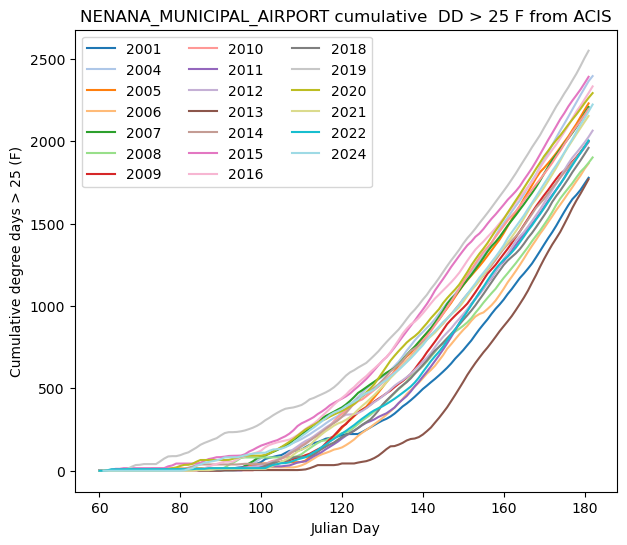

In [ ]:
name = "NENANA_MUNICIPAL_AIRPORT"

plotdf = pd.read_csv(outpath / f"dd_cumul_bystation/{name}_yearly_{prefix}_cumul.csv", header=4, index_col=0 )

fig, ax = plt.subplots(figsize=(7, 6))

colors = plt.cm.tab20(np.linspace(0, 1, len(plotdf.columns)))
plotdf.plot(color=colors, legend=False, ax=ax, title=f"{name} cumulative  DD > {config[prefix]['deltaT']} F from ACIS")
ax.legend(fontsize=10, ncol=3, loc='upper left')
ax.set_xlabel('Julian Day')
ax.set_ylabel(f'Cumulative degree days > {config[prefix]["deltaT"]} (F)')


Text(0, 0.5, 'Cumulative degree days > 25 (F)')

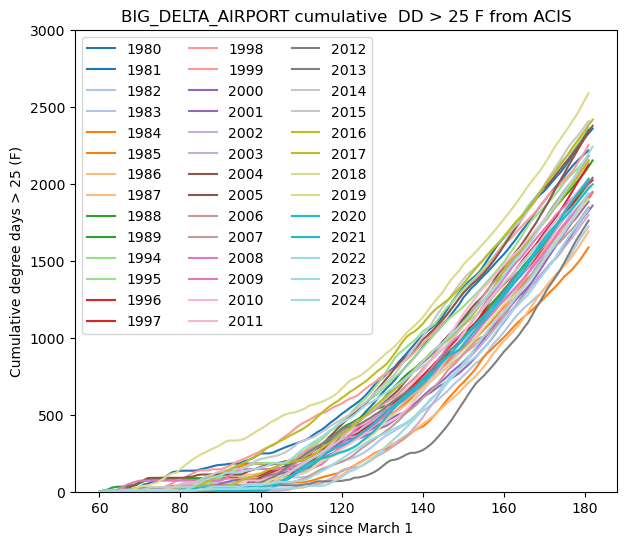

In [ ]:
name = "BIG_DELTA_AIRPORT"

plotdf = pd.read_csv(outpath / f"dd_cumul_bystation/{name}_yearly_{prefix}_cumul.csv", header=4, index_col=0 )

fig, ax = plt.subplots(figsize=(7, 6))

colors = plt.cm.tab20(np.linspace(0, 1, len(plotdf.columns)))
plotdf.plot(color=colors, legend=False, ax=ax, ylim=[0, 3000],
            title=f"{name} cumulative  DD > {config[prefix]['deltaT']} F from ACIS")
ax.legend(fontsize=10, ncol=3, loc='upper left')
ax.set_xlabel('Days since March 1')
ax.set_ylabel(f'Cumulative degree days > {config[prefix]["deltaT"]} (F)')

Text(0, 0.5, 'Cumulative degree days >  TDD  (F)')

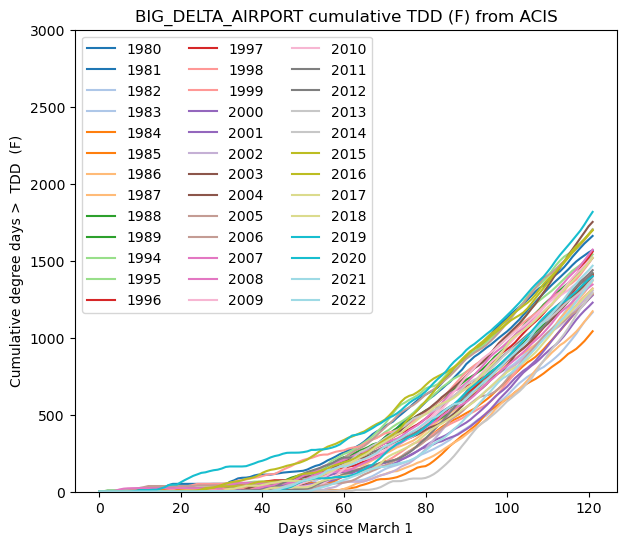

In [ ]:
name = "BIG_DELTA_AIRPORT"
#fp = Path("/Users/christine/Projects/2023_Riverice/data/weatherstations/ACIS/TDD/tdd_cumul_bystation/BIG_DELTA_AP_yearly_TDD_cumul.csv
fp = Path(f"{PROJPATH}/data/weatherstations/ACIS/TDD/tdd_cumul_bystation/BIG_DELTA_AP_yearly_TDD_cumul.csv")
plotdf = pd.read_csv(fp , header=4, index_col=0 )

fig, ax = plt.subplots(figsize=(7, 6))

colors = plt.cm.tab20(np.linspace(0, 1, len(plotdf.columns)))
plotdf.plot(color=colors, legend=False, ax=ax, ylim=[0, 3000],
            title=f"{name} cumulative TDD (F) from ACIS")
ax.legend(fontsize=10, ncol=3, loc='upper left')
ax.set_xlabel('Days since March 1')
ax.set_ylabel(f'Cumulative degree days >  TDD  (F)')

## Prototyping area

In [ ]:
testdf = get_dddf(testdf)


In [ ]:
testdf[(testdf.year > 1990) & (testdf.year < 2021)].replace(-9999, np.nan)

,year,julian_day,Tavg_F,dd,dd_cumul
4017,1991,1,-39.0,0.0,0.0
4018,1991,2,-39.0,0.0,0.0
4019,1991,3,-36.5,0.0,0.0
4020,1991,4,-27.0,0.0,0.0
4021,1991,5,-31.0,0.0,0.0
...,...,...,...,...,...
14970,2020,362,14.5,0.0,4644.0
14971,2020,363,14.0,0.0,4644.0
14972,2020,364,15.0,0.0,4644.0
14973,2020,365,8.0,0.0,4644.0


In [ ]:
testdf = get_MAMJ_dd(station2df(stations[1]))
missing = pd.DataFrame(testdf[testdf.Tavg_F==-9999].groupby('year').size().rename('count_missing'))
significant_missing = missing[missing.count_missing > 5]
mising_sig_climatology_years = set(significant_missing.index).intersection(set(range(1991, 2021)))
testdf = testdf[(testdf.year > 1990) & (testdf.year < 2021) & (~testdf.year.isin(mising_sig_climatology_years))].replace(-9999, np.nan)
testdf['Tavg_F'] = testdf.Tavg_F.astype(float)
testdf = testdf.interpolate(method='linear', axis=0)
climatology = pd.DataFrame(get_pivotdf(get_dddf(testdf), value='Tavg_F').mean(axis=1), columns=['Tavg_F'])
climatology['tdd'] = climatology['Tavg_F'] - 32
climatology.loc[climatology['tdd'] < 0, 'tdd'] = 0

<AxesSubplot: xlabel='d_since_march1'>

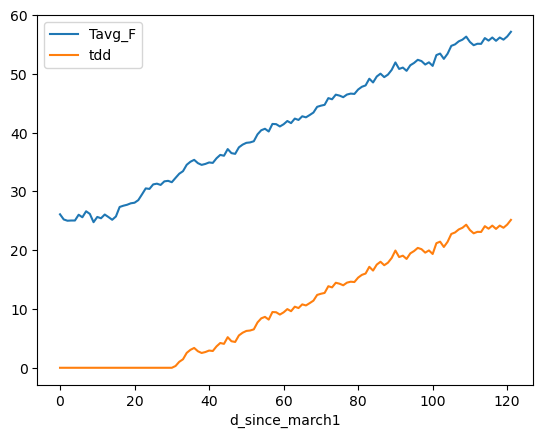

In [ ]:
climatology.plot()

In [ ]:
climatology

,Tavg_F,tdd
d_since_march1,,
0,25.173913,0.000000
1,24.543478,0.000000
2,24.913043,0.000000
3,24.760870,0.000000
4,25.434783,0.000000
5,26.652174,0.000000
6,25.456522,0.000000
7,26.586957,0.000000
8,26.326087,0.000000


In [ ]:
pd.set_option('display.max_rows', 150)

In [ ]:
mising_sig_climatology_years

{1991, 1992, 1994, 2003, 2004, 2009, 2012}

In [ ]:
significant_missing

,count_missing
year,
1980,102
1981,42
1982,36
1983,23
1984,14
1989,35
1991,6
1992,9
1994,6
